### Load data

In [1]:
from trane.parsing import denormalize, denormalize2
import pandas as pd
from util import load_data

dataframes, relationships = load_data()

df = denormalize(
    dataframes,
    relationships,
    "order_products"
)
df = df.dropna()

df["orders.user_id"] = df["orders.user_id"].astype("int")

## Trane

In [2]:
from trane import CutoffStrategy
from trane.typing.column_schema import ColumnSchema
from trane.typing.logical_types import (
    Categorical,
    Datetime,
    Double,
    Integer,
)

entity_col = "orders.user_id"
time_col = "orders.order_date"

def get_meta(df, entity_col):
    meta = {}
    for col in df.columns:
        if df[col].dtype == "int":
            meta[col] = ColumnSchema(
                Integer,
                semantic_tags=({"numeric"} if col != entity_col else {"numeric", "index"})
            )
        if df[col].dtype == "float":
            meta[col] = ColumnSchema(
                Double,
                semantic_tags=({"numeric"} if col != entity_col else {"numeric", "index"})
            )
        if df[col].dtype == "object":
            meta[col] = ColumnSchema(
                Categorical,
                semantic_tags=({"category"} if col != entity_col else {"category", "index"})
            )
        if df[col].dtype == "datetime64[ns]":
            meta[col] = ColumnSchema(
                Datetime,
                semantic_tags=({} if col != entity_col else {"index"})
            )
    return meta
meta = get_meta(df, entity_col)

cutoff_strategy = CutoffStrategy(
    entity_col=entity_col,
    window_size="2w",
    minimum_data="2023-01-01",
    maximum_data="2023-10-01",
)


#### Generate prediction problems

In [3]:
from trane import PredictionProblemGenerator
problem_generator = PredictionProblemGenerator(
    df=df,
    table_meta=meta,
    entity_col=entity_col,
    cutoff_strategy=cutoff_strategy,
    time_col=time_col,
)
problems = problem_generator.generate(df, generate_thresholds=True)

  0%|          | 0/4845 [00:00<?, ?it/s]

In [4]:
import numpy as np
for problem in np.array(problems)[np.random.choice(range(len(problems)), 10)]:
    print(problem)

For each <orders.user_id> predict the number of records with <orders.eval_set> equal to prior in next 2w days
For each <orders.user_id> predict the total <reordered> in all related records with <product_id> greater than 40606 in next 2w days
For each <orders.user_id> predict the maximum <reordered> in all related records with <order_id> less than 1282983 in next 2w days
For each <orders.user_id> predict the total <products.aisle_id> in all related records with <products.department_id> greater than 4 in next 2w days
For each <orders.user_id> predict if there exists a record with with <products.aisles.aisle> equal to fresh vegetables in next 2w days
For each <orders.user_id> predict the maximum <order_id> in all related records with <products.aisles.aisle> equal to fresh fruits in next 2w days
For each <orders.user_id> predict the minimum <reordered> in all related records with <reordered> less than 1 in next 2w days
For each <orders.user_id> predict the maximum <orders.days_since_prior_

Find a relevant problem

In [30]:
with open("generated_problems.txt", "w") as text_file:
    for idx, p in enumerate(problems):
        print(idx, p, file=text_file)

In [6]:
ex = problems[3781].execute(df, num_examples_per_instance=-1)
problems[3781]

Elapsed: 00:41 | Remaining: 00:00 | Progress: 100%|██████████| orders.user_id: 10000/10000 


For each <orders.user_id> predict if there exists a record with with <products.product_name> equal to Bag of Organic Bananas in next 2w days

#### Generate features

/opt/miniconda3/envs/trane2/lib/python3.10/site-packages/featuretools/entityset/entityset.py:1910: UserWarning: index id not found in dataframe, creating new integer column
  warnings.warn(


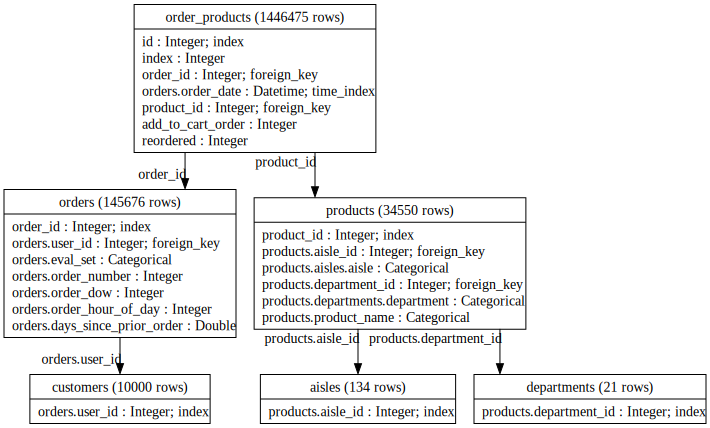

In [7]:
import featuretools as ft
es = ft.EntitySet('instacart')

es.add_dataframe(
    dataframe=df.reset_index(),
    dataframe_name='order_products',
    time_index='orders.order_date',
    index='id',
)

es.normalize_dataframe(
    base_dataframe_name='order_products',
    new_dataframe_name='orders',
    index='order_id',
    additional_columns=[col for col in df.columns if col.startswith('orders.') and col != "orders.order_date"],
    make_time_index=False,
)

es.normalize_dataframe(
    base_dataframe_name='orders',
    new_dataframe_name='customers',
    index='orders.user_id',
    make_time_index=False,
)

es.normalize_dataframe(
    base_dataframe_name='order_products',
    new_dataframe_name='products',
    index='product_id',
    additional_columns=[col for col in df.columns if col.startswith('products')],
    make_time_index=False,
)

es.normalize_dataframe(
    base_dataframe_name='products',
    new_dataframe_name='aisles',
    index='products.aisle_id',
    make_time_index=False,
)

es.normalize_dataframe(
    base_dataframe_name='products',
    new_dataframe_name='departments',
    index='products.department_id',
    make_time_index=False,
)

es.plot()

In [8]:
fm, fd = ft.dfs(
    entityset=es,
    target_dataframe_name='customers',
    cutoff_time=ex,
    cutoff_time_in_index=True,
    include_cutoff_time=False,
    verbose=True,
)

fm.head()

Built 170 features
Elapsed: 03:37 | Progress: 100%|██████████


COUNT(orders)  \
orders.user_id time                        
1              2023-02-12              9   
               2023-08-13              9   
               2023-08-27              9   
               2023-09-10              9   
2              2023-03-12             13   

                           MAX(orders.orders.days_since_prior_order)  \
orders.user_id time                                                    
1              2023-02-12                                       30.0   
               2023-08-13                                       30.0   
               2023-08-27                                       30.0   
               2023-09-10                                       30.0   
2              2023-03-12                                       30.0   

                           MAX(orders.orders.order_dow)  \
orders.user_id time                                       
1              2023-02-12                           4.0   
               2023-08-13                           4.0   
               2023-08-27                           4.0   
               2023-09-10                           4.0   
2              2023-03-12                           5.0   

                           MAX(orders.orders.order_hour_of_day)  \
orders.user_id time                                               
1              2023-02-12                                  16.0   
               2023-08-13                                  16.0   
               2023-08-27                                  16.0   
               2023-09-10                                  16.0   
2              2023-03-12                                  15.0   

                           MAX(orders.orders.order_number)  \
orders.user_id time                                          
1              2023-02-12                             10.0   
               2023-08-13                             10.0   
               2023-08-27                             10.0   
               2023-09-10                             10.0   
2              2023-03-12                             14.0   

                           MEAN(orders.orders.days_since_prior_order)  \
orders.user_id time                                                     
1              2023-02-12                                   19.555556   
               2023-08-13                                   19.555556   
               2023-08-27                                   19.555556   
               2023-09-10                                   19.555556   
2              2023-03-12                                   15.230769   

                           MEAN(orders.orders.order_dow)  \
orders.user_id time                                        
1              2023-02-12                       2.555556   
               2023-08-13                       2.555556   
               2023-08-27                       2.555556   
               2023-09-10                       2.555556   
2              2023-03-12                       2.153846   

                           MEAN(orders.orders.order_hour_of_day)  \
orders.user_id time                                                
1              2023-02-12                              10.555556   
               2023-08-13                              10.555556   
               2023-08-27                              10.555556   
               2023-09-10                              10.555556   
2              2023-03-12                              10.538462   

                           MEAN(orders.orders.order_number)  \
orders.user_id time                                           
1              2023-02-12                               6.0   
               2023-08-13                               6.0   
               2023-08-27                               6.0   
               2023-09-10                               6.0   
2              2023-03-12                               8.0   

                           MIN(orders.orde

X and y

In [9]:
fm.reset_index(drop=True, inplace=True)
y = fm.ww.pop('_execute_operations_on_df')

### AutoML

#### BTB

In [28]:
from sklearn.datasets import load_wine
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import warnings

models = {
    'LGB': lgb.LGBMClassifier,
    'XGB': xgb.XGBClassifier,
    'DTC': DecisionTreeClassifier,
    'SGDC': SGDClassifier,
    'RF': RandomForestClassifier,
}

def scoring_function(model_name, hyperparameter_values):
    model_class = models[model_name]
    model_instance = model_class(**hyperparameter_values)
    print(model_instance)
    skf = StratifiedKFold(n_splits=5)
    scores = cross_val_score(
        estimator=model_instance,
        X=fm,
        y=y,
        scoring=make_scorer(roc_auc_score),
        cv=skf,
        n_jobs=-1
    )
    return scores.mean()

from btb.tuning import Tunable
from btb.tuning import hyperparams as hp

tunables = {
    'LGB': Tunable({
        'num_leaves': hp.IntHyperParam(min=2, max=100),
        'max_depth': hp.IntHyperParam(min=3, max=200),
        'learning_rate': hp.FloatHyperParam(min=0.01, max=1),
        'n_estimators': hp.IntHyperParam(min=10, max=1000),
    }),
    'XGB': Tunable({
        'max_depth': hp.IntHyperParam(min=3, max=200),
        'learning_rate': hp.FloatHyperParam(min=0.01, max=1),
        'n_estimators': hp.IntHyperParam(min=10, max=1000),
    }),
    'DTC': Tunable({
        'max_depth': hp.IntHyperParam(min=3, max=200),
        'min_samples_split': hp.FloatHyperParam(min=0.01, max=1)
    }),
    'SGDC': Tunable({
        'max_iter': hp.IntHyperParam(min=1, max=5000, default=1000),
        'tol': hp.FloatHyperParam(min=1e-3, max=1, default=1e-3),
    }),
    'RF': Tunable({
        'n_estimators': hp.IntHyperParam(min=10, max=1000),
        'max_depth': hp.IntHyperParam(min=3, max=200),
        'min_samples_split': hp.FloatHyperParam(min=0.01, max=1),
    }),
}

from btb import BTBSession

session = BTBSession(
    tunables=tunables,
    scorer=scoring_function,
    verbose=True
)

best_proposal = session.run(10)

  0%|          | 0/10 [00:00<?, ?it/s]

LGBMClassifier(learning_rate=0.01, max_depth=3, n_estimators=10, num_leaves=2)
[LightGBM] [Info] Number of positive: 8725, number of negative: 49589
[LightGBM] [Info] Number of positive: 8725, number of negative: 49589
[LightGBM] [Info] Number of positive: 8725, number of negative: 49589
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28876
[LightGBM] [Info] Number of data points in the train set: 58314, number of used features: 161
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149621 -> initscore=-1.737577
[LightGBM] [Info] Start training from score -1.737577
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

In [29]:
best_proposal

{'id': '402ebd3e75a65094b407b95a1234c4af',
 'name': 'LGB',
 'config': {'num_leaves': 93,
  'max_depth': 157,
  'learning_rate': 0.8469614394623889,
  'n_estimators': 408},
 'score': 0.5196958961426631}